In [38]:
import datetime as dt
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns 
import datetime

# Import Facebook Prophet
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# Set default plotting parameters
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams.update({'font.size': 16})

# Set Random seed for reproducability
import random
random.seed(1234)

# Context: 
- Stripe Connect is a product that allows platform businesses to pay out money to other businesses all over the world. In this project, you will analyze the payout behavior of Stripe platforms. A platform is a Stripe user that enables other businesses to process payments with Stripe.
***
#### Given: 
- payouts.csv: contains Stripe Connect payout data for 2018.
- countries.csv: lookup table for merchant id's corresponding country.
- industries.csv: lookup table for merchant id's corresponding industry.

#### Data:
- The dataset `payouts.csv` has daily payout amounts (in cents) from platforms to recipients. Both platforms and recipients are represented by a merchant id. In the dataset, the platform merchant is specified by `platform_id` and the recipient is specified by `recipient_id`. 
- The dataset `countries.csv` maps merchants to countries.
- The dataset `industries.csv` maps merchants to industries.

#### Questions: 
- Using the data provided, please provide an estimate for the amount of money we should expect to be paid out to each country on Jan. 1, 2019 (the day after the last day in the dataset).
- Assume that one year from the end of the dataset, we will have 15 platforms from the Education industry, 5 from Hotels, Restaurants & Leisure and 40 from Food & Beverage. How much total payout volume do you expect to see on a typical day in 2019, from these three industries?

#### Helper Functions

In [39]:
# Function to reformat numbers: ex: 1000 => 1K
def format_number(n, sig=1):
    unit_names = ['', 'K', 'M', 'B']
    n = float(n)
    unit_idx = max(0, min(len(unit_names)-1,
                          int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))
    if sig == 0:
        return '{:.0f}{}'.format(n / 10**(3*unit_idx), unit_names[unit_idx])
    else:
        return '{:.1f}{}'.format(n / 10**(3*unit_idx), unit_names[unit_idx])

# Data Exploration
***



### Read in raw datasets

In [74]:
payouts = pd.read_csv('payouts.csv')
payouts.head()

,date,platform_id,recipient_id,count,amount
0,2018-05-16 00:00:00+00:00,id_5dded1fc8ff3f8c0d96019076394d2a7,id_23d90ec275370c686dedd7dc1c5e93b3,1,9786.0
1,2018-11-23 00:00:00+00:00,id_424316eb0d974bebd1736fc4bd2eac3d,id_72f05535ba5e6e5b141db6b5c1f1b13b,1,3750.0
2,2018-08-07 00:00:00+00:00,id_3702c1be346117616974e4127c952ab7,id_d70e8046fe5583e1154b2e077133e27c,1,2258.0
3,2018-07-10 00:00:00+00:00,id_a1eafb7ca12772d4e8770b9b3566e608,id_1a336bd21b4bfd9810e0510e1a5f7ec2,1,20369.0
4,2018-01-07 00:00:00+00:00,id_a1eafb7ca12772d4e8770b9b3566e608,id_c577aeddec71607ec0be1f94bef025da,1,34922.0


In [75]:
industries = pd.read_csv('industries.csv')
industries.head()

,merchant_id,industry
0,id_ace715763434d4fd4eda58c9e9d692c6,Travel & Hospitality
1,id_717b4a0f74912f18146c0708b330a3d9,Food & Beverage
2,id_671fd54bccd294b502fea89c0cc5a690,Professional Services (non-medical)
3,id_d8ed94b4e446b868e38efa8efa34b702,Travel & Hospitality
4,id_1a054e523cbf203b16b38fc3e5b19b25,Professional Services (non-medical)


In [77]:
countries = pd.read_csv('countries.csv')
countries.head()

,merchant_id,country
0,id_ace715763434d4fd4eda58c9e9d692c6,FR
1,id_717b4a0f74912f18146c0708b330a3d9,US
2,id_671fd54bccd294b502fea89c0cc5a690,US
3,id_d8ed94b4e446b868e38efa8efa34b702,FR
4,id_1a054e523cbf203b16b38fc3e5b19b25,US


### Combine Raw Datasets into payouts df

In [78]:
payouts['platform_industry'] = payouts.merge(industries, how='left', left_on='platform_id', right_on='merchant_id')['industry']
payouts['recipient_industry'] = payouts.merge(industries, how='left', left_on='recipient_id', right_on='merchant_id')['industry']
payouts['platform_country'] = payouts.merge(countries, how='left', left_on='platform_id', right_on='merchant_id')['country']
payouts['recipient_country'] = payouts.merge(countries, how='left', left_on='recipient_id', right_on='merchant_id')['country']

In [79]:
payouts['platform_country_industry'] = payouts.merge(countries, how='left', left_on='recipient_id', right_on='merchant_id')['country'] + " - " + payouts.merge(industries, how='left', left_on='recipient_id', right_on='merchant_id')['industry']
payouts['recipient_country_industry'] = payouts.merge(countries, how='left', left_on='platform_id', right_on='merchant_id')['country'] + " - " + payouts.merge(industries, how='left', left_on='platform_id', right_on='merchant_id')['industry']

### Determine Data Dimensionality

In [80]:
print("Number of Platforms: {}".format(payouts['platform_id'].nunique()))
print("Number of Recipients: {}".format(payouts['recipient_id'].nunique()))
print("Number of Platform Industries: {}".format(payouts['platform_industry'].nunique()))
print("Number of Recipient Industries: {}".format(payouts['recipient_industry'].nunique()))
print("Number of Platform Countries: {}".format(payouts['platform_country'].nunique()))
print("Number of Recipient Countries: {}".format(payouts['recipient_country'].nunique()))

print("=====================")

print("Number of Combinations of Platform Countries + Industries: {}".format(payouts['platform_country_industry'].nunique()))
print("Number of Combinations of Platform Countries + Industries: {}".format(payouts['recipient_country_industry'].nunique()))

Number of Platforms: 463
Number of Recipients: 112030
Number of Platform Industries: 17
Number of Recipient Industries: 13
Number of Platform Countries: 25
Number of Recipient Countries: 25
Number of Combinations of Platform Countries + Industries: 172
Number of Combinations of Platform Countries + Industries: 93


### This is an imbalanced dataset, which will negatively impact predictive power on minority classes

In [81]:
payouts.groupby(['recipient_country'])['amount'].count().sort_values(ascending=False)

recipient_country
US    1232538
FR     118390
HK      50359
CA      32802
JP      32082
GB      28495
AU      25855
BR      22312
ES      18782
BE      13557
DE      10701
IE       3734
AT       3508
NO       2604
IT       2536
NZ       2232
SE       1965
DK       1786
NL       1603
CH       1402
FI        850
SG        627
PT        540
LU        143
MX         73
Name: amount, dtype: int64

### Check for null values
- There are a number null platform countries/industries.
- This means that some of the platform payout amounts are not able to be properly grouped by country/industry

In [82]:
print("Number of Null Platform Ids: {}".format(payouts.platform_id.isna().sum()))
print("Number of Null Recipient Ids: {}".format(payouts.recipient_id.isna().sum()))
print("Number of Null Platform Countries: {}".format(payouts.platform_country.isna().sum()))
print("Number of Null Recipient Countries: {}".format(payouts.recipient_country.isna().sum()))
print("Number of Null Platform Industries: {}".format(payouts.platform_industry.isna().sum()))
print("Number of Null Recipient Industries: {}".format(payouts.recipient_industry.isna().sum()))
print("Number of Null Amounts: {}".format(payouts.amount.isna().sum()))
print("Number of Null Counts: {}".format(payouts['count'].isna().sum()))

Number of Null Platform Ids: 0
Number of Null Recipient Ids: 0
Number of Null Platform Countries: 205
Number of Null Recipient Countries: 13166
Number of Null Platform Industries: 210
Number of Null Recipient Industries: 13166
Number of Null Amounts: 0
Number of Null Counts: 0


### Payout Ranges
- There are negative payout values. This indicates a chargeback, refund, or fee charged by the platform

#### Convert Amount from cents to dollars

In [83]:
payouts['amount'] = payouts['amount'] / 100
print('Min Payout: {}'.format(payouts.amount.min()))
print('Mean Payout: {}'.format(payouts.amount.mean()))
print('Max Payout: {}'.format(payouts.amount.max()))


Min Payout: -261391.1
Mean Payout: 828.8796280325544
Max Payout: 3981618.06


### Plot average Global Payouts
There appears to be a degree of seasonality and little, if any, systemic trend over the year

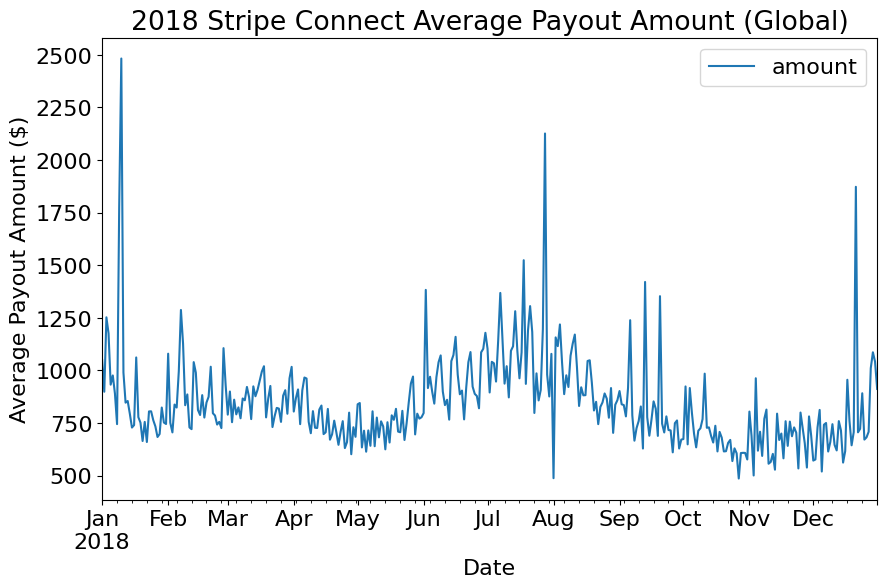

In [84]:
payouts_amt = payouts[['amount']].groupby(payouts.date)[['amount']].mean()
payouts_amt.sort_index(ascending=True, inplace=True)
payouts_amt.index = pd.to_datetime(payouts_amt.index)

payouts_amt.plot();
plt.legend()
plt.xlabel('Date');
plt.ylabel('Average Payout Amount ($)');
plt.title('2018 Stripe Connect Average Payout Amount (Global)');
plt.show();

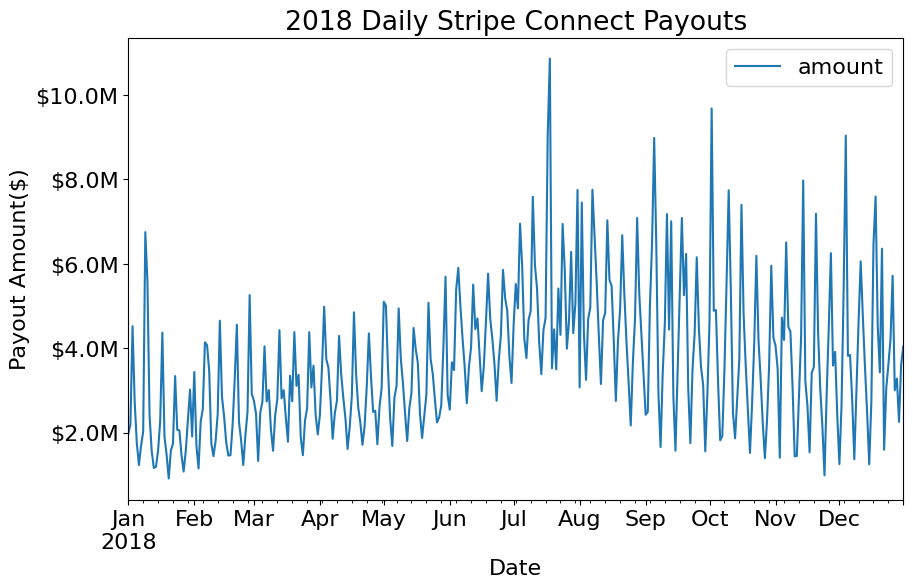

In [85]:
fig, ax = plt.subplots()
payouts_amt = payouts[['amount']].groupby(payouts.date)[['amount']].sum()
payouts_amt.sort_index(ascending=True, inplace=True)
payouts_amt.index = pd.to_datetime(payouts_amt.index)


payouts_amt.plot(ax=ax);
plt.legend()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '${}'.format(format_number(x))))

ax.set_xlabel('Date');
ax.set_ylabel('Payout Amount($)');
ax.set_title('2018 Daily Stripe Connect Payouts');
plt.show();

### Plot Payout Volatility

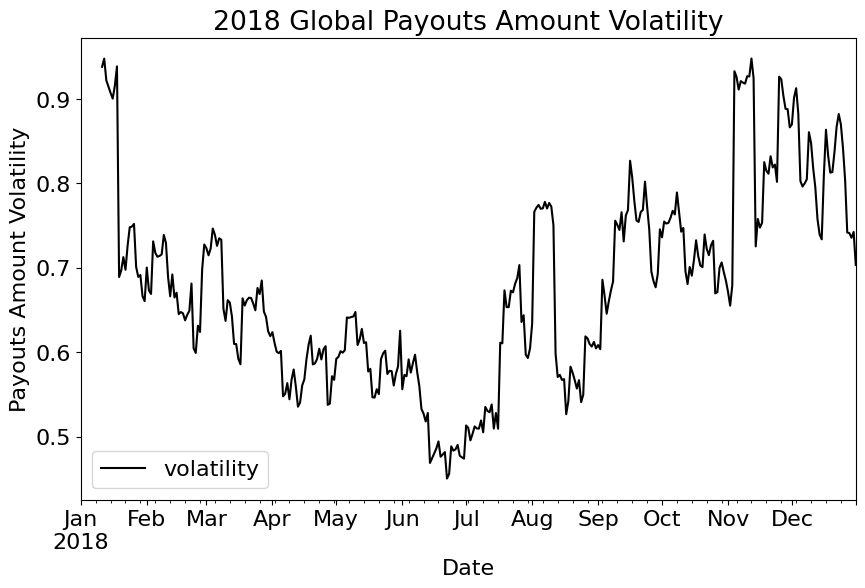

In [86]:
plt.clf()
window = 10

payouts_amt['volatility'] = payouts_amt.pct_change().rolling(window).std()**0.5
payouts_amt['volatility'].plot(color='k');
plt.legend()
plt.xlabel('Date');
plt.ylabel('Payouts Amount Volatility') ;
plt.title('2018 Global Payouts Amount Volatility');
plt.show()

### Plot Payouts Distribution
- Payouts Amount distribution is right-skewed with a mean value of ~828
- There are a small number of negative payout amounts (indicating the presence of chargebacks, refunds, etc.)

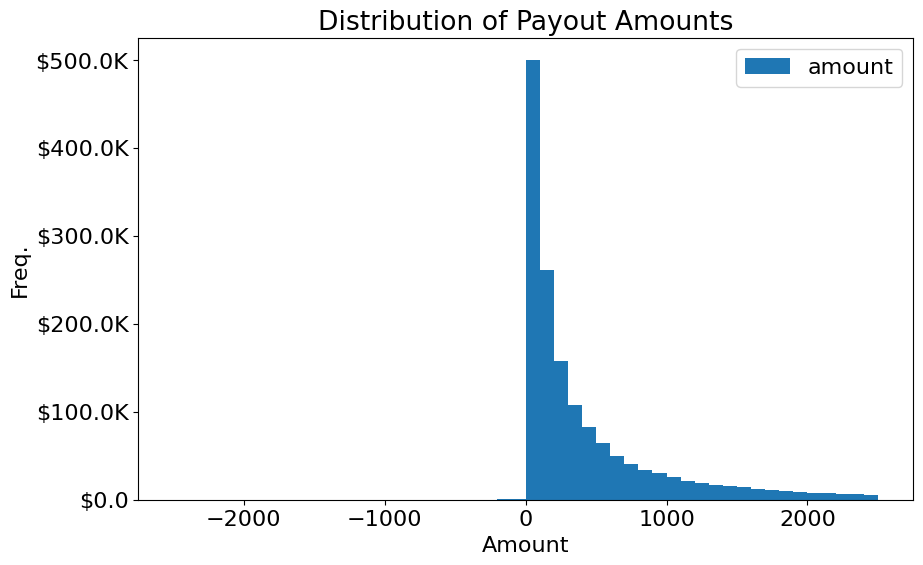

In [87]:
fig, ax = plt.subplots()
ax.hist(payouts['amount'], bins=50, range=(-2500, 2500), label='amount')

ax.set_xlabel('Amount')
ax.set_ylabel('Freq.')
ax.set_title('Distribution of Payout Amounts')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '${}'.format(format_number(x))))
ax.legend()
plt.show()

### Payouts Ranges by Country
**Takeaway:** The United States accounts for the vast majority of Payouts. Boxplots show variability in payout amount differing between countries. Mexico and Italy have particularly pronounced payout variability.

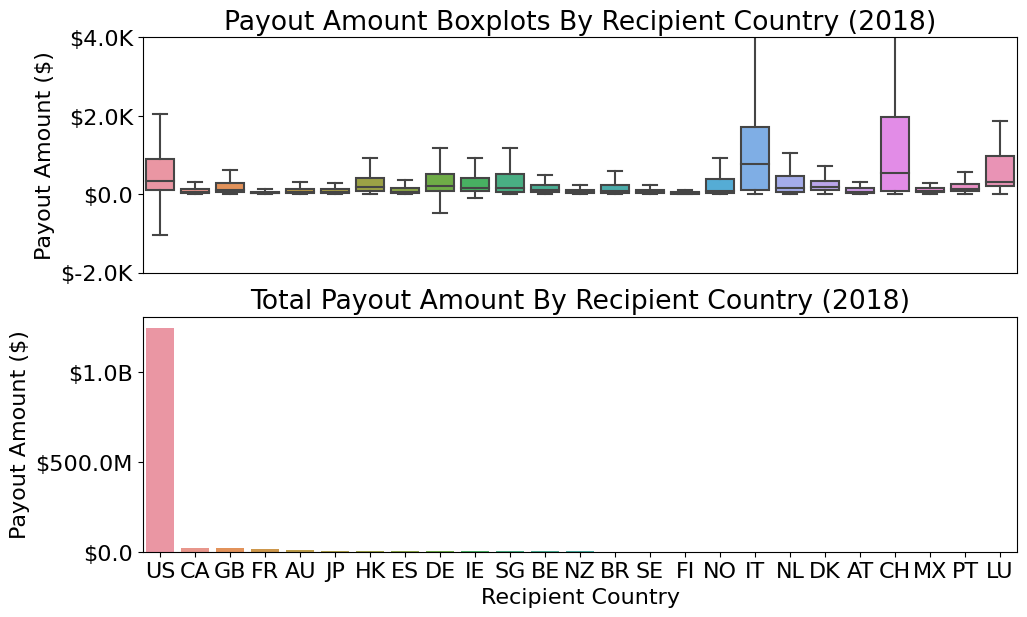

In [88]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.tight_layout()

#===== Plot 1: Boxplots of payouts amount by Recipient Country
# Set upper y limit on boxplots because Mexico is an outlier 
ax1.set_ylim([-2000, 4000])
sns.boxplot(x='recipient_country',
            y='amount',data=payouts, 
            showfliers=False, 
            ax=ax1)
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '${}'.format(format_number(x))))
ax1.set_title('Payout Amount Boxplots By Recipient Country (2018)')
ax1.get_xaxis().set_visible(False)
ax1.set_ylabel('Payout Amount ($)')

#===== Plot 2: Plots of Total Payout Amount by Recipient Country
recipient_country_amt = payouts[['recipient_country', 'amount']].groupby(['recipient_country'])['amount'].sum().reset_index()
recipient_country_amt.sort_values(by='amount', ascending=False, inplace=True)
sns.barplot(x=recipient_country_amt.recipient_country,
            y=recipient_country_amt.amount,
            data=recipient_country_amt,
            ax=ax2)
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '${}'.format(format_number(x))))
ax2.set_title('Total Payout Amount By Recipient Country (2018)')
ax2.set_ylabel('Payout Amount ($)')
ax2.set_xlabel('Recipient Country')


plt.show()

# Question 1
**Question:** Using the data provided, please provide an estimate for the amount of money we should expect to be paid out to each country on Jan. 1, 2019 (the day after the last day in the dataset).
***

### Create dataframe with payout amount aggregated by recipient country

In [89]:
agg_df = pd.pivot_table(payouts, index=['recipient_country', 'date'],values=['amount'], aggfunc=np.sum)
agg_df = agg_df.sort_index()
agg_df.columns = ['total_amount']
agg_df = agg_df.reset_index()

## Create Forecasts of daily payouts for each country

**Forecasting Methodology:**
- Use Facebook Prophets model, which will decompose trends and seasonality, to forecast 2019 average daily payouts for each country


In [90]:
prophets = {}

for country in agg_df.recipient_country.unique():
    """
    Create dataframe with columns:
    ds: datestamp
    y:  observed payout amount for a given datestamp
    cap: highest payout amount observed
    floor: lowest payout amount observed
    """
    # Convert to datetime object to strip timezone formatting
    agg_df.date = pd.to_datetime(agg_df.date).dt.strftime("%m/%d/%Y").astype('datetime64[ns]')

    # Create country specific df
    agg_country_df = agg_df.loc[agg_df.recipient_country == country]

    # Create date range to fill
    r = pd.date_range(start=agg_country_df.date.min(), end=datetime.date(2018, 12, 31))
    df = pd.DataFrame(r, columns=['ds'])

    df = df.merge(agg_country_df[['date', 'total_amount']], how='left', left_on='ds', right_on='date')
    df = df[['ds', 'total_amount']]
    df['cap'] = agg_df.loc[agg_df.recipient_country == country].total_amount.max()
    df['floor'] = agg_df.loc[agg_df.recipient_country == country].total_amount.min()
    df.fillna(0, inplace=True)
    df.columns = ['ds', 'y', 'cap', 'floor']

    prophet = Prophet(growth='linear',
                      n_changepoints=50,
                      changepoint_range=0.9,
                      yearly_seasonality=False,
                      weekly_seasonality=True,
                      daily_seasonality=True)
    prophet.fit(df)
    future = prophet.make_future_dataframe(periods=10, freq='D')
    forecast = prophet.predict(future)
    
    prophets[country] = (prophet, forecast)



#### Create helper functions for plotting/accessing forecast data

In [91]:
def plot_forecast(country):
    plt.clf()
    prophet = prophets[country][0]
    forecast = prophets[country][1]
    fig = prophet.plot(forecast);
    ax1 = fig.axes[0]
    ax1.axvline(x=datetime.date(2019, 1, 1), label='Start of Forecast', color='dimgray', linewidth=2)
    ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '${}'.format(format_number(x))))
    plt.legend(loc='upper right')
    plt.title('{} 10 Day Forecast'.format(country))
    return fig

def get_yhat(country):
    
    forecast = prophets[country][1]
    yhat_lower = forecast.loc[forecast.ds == '2019-01-01']['yhat_lower'].values[0]
    yhat = forecast.loc[forecast.ds == '2019-01-01']['yhat'].values[0]
    yhat_upper = forecast.loc[forecast.ds == '2019-01-01']['yhat_upper'].values[0]
    return yhat_lower, yhat, yhat_upper

### Example forecast data plot for US
**Prophet Plots Explanation:**
- Source: https://www.mikulskibartosz.name/prophet-plot-explained/ 
- Black dots: data used to train model
- Dark Blue Line: Predicted Output
- Light Blue Region: Uncertainty Intervals

<Figure size 1000x600 with 0 Axes>

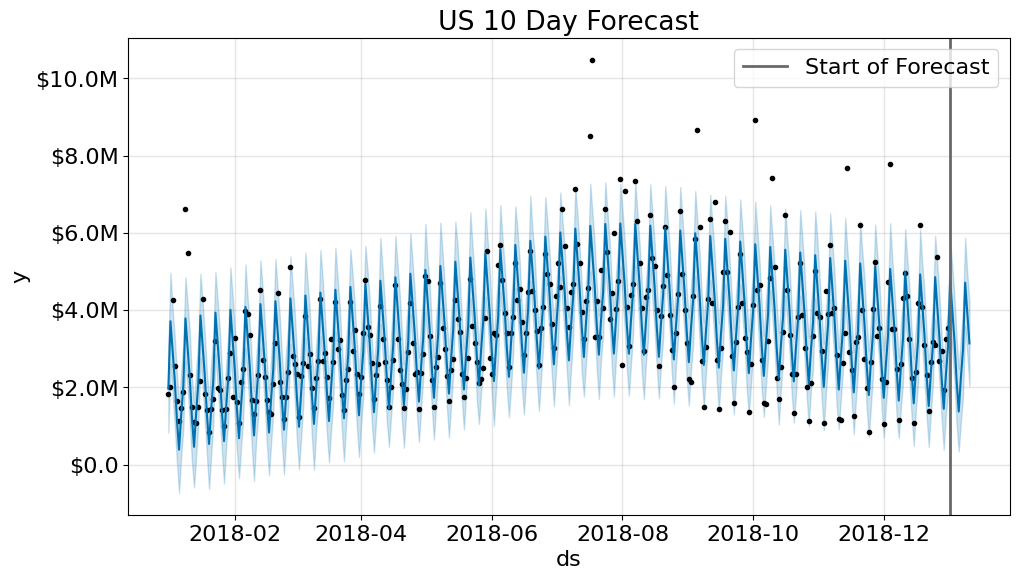

In [92]:
plot_forecast('US')
plt.show()

## Question 1 Final Graph: bar chart of forecasted payouts by country on 1/1/2019

<Figure size 1000x600 with 0 Axes>

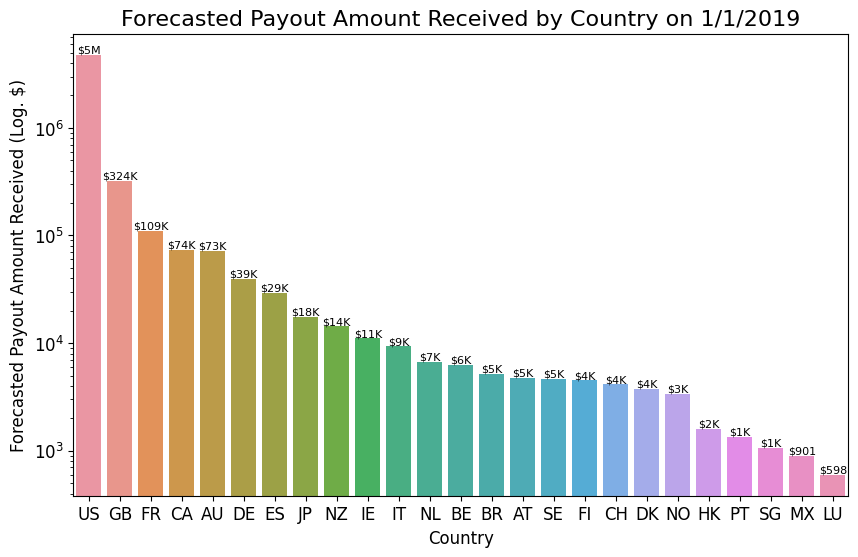

In [93]:
plt.clf()

# Aggregate forecasts for each country into the yhats DataFrame
lst = []
yhats = pd.DataFrame()
for country in agg_df.recipient_country.unique():
    yhat_lower, yhat, yhat_upper = get_yhat(country)
    lst.append(yhat)
yhats['country'] = agg_df.recipient_country.unique()
yhats['yhat'] = lst
yhats = yhats.sort_values('yhat', ascending=False)
    
# Plot the yhats DataFrame
fig, ax = plt.subplots()
sns.barplot(x=yhats.country,
            y=yhats.yhat,
            data=yhats,
            ax=ax)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '${}'.format(format_number(x))))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

ax.set_yscale('log')

ax.set_ylabel('Forecasted Payout Amount Received (Log. $)', fontdict={'fontsize':12})
ax.set_xlabel('Country', fontdict={'fontsize':12})
ax.set_title('Forecasted Payout Amount Received by Country on 1/1/2019', fontdict={'fontsize':16})

# Add Data Labels for top 3 countries + for some of the lower amounts 
for idx, p in enumerate(ax.patches):
#     if idx % 11 == 0 or p.get_height() >= 100000:
        # Reference for adding bar plot data labels: https://stackoverflow.com/questions/39444665/add-data-labels-to-seaborn-factor-plot 
    ax.text(p.get_x() + p.get_width()/2, p.get_height(), '${}'.format(format_number(p.get_height(), sig=0)), 
            fontsize=8, color='k', ha='center', va='bottom')
plt.show()

In [94]:
print('We averaged paying out {0} to {1} different countries in 2018'.format(round(yhats.yhat.sum()), yhats.country.nunique()))

We averaged paying out 5533902 to 25 different countries in 2018


# Question 2)

**Question:** Assume that one year from the end of the dataset, we will have 15 platforms from the Education industry, 5 from Hotels, Restaurants & Leisure and 40 from Food & Beverage. How much total payout volume do you expect to see on a typical day in 2019, from these three industries?

**Forecasting Methodology**
- Use Facebook Prophets model, which will decompose trends and seasonality, to forecast 2019 average daily payouts for each country
- Use average daily payout amount per platform in each of the 3 target industries to forecast future daily payout amount per platform per industry
- multiply forecasted daily payout amount per platform per industry by the scalars provided in the problem statement 

#### Key Assumption: Since there was only 1 platform payout in 2018 for Hotels, Restaurants & Leisure, I will forecast growth in this industry by approximating with the Travel & Hospitality Industry 

**Future Average Daily Payout** = (15 * avg Education payout) + (5 * avg Travel & Hospitality Industry payout) + (40 * avg Food & Beverage payout)

## Create dataframe with daily total payout amount each each target industry 

In [95]:
# Define Target Industries
target_industries = ['Education', 'hotels, restaurants & leisure', 'Food & Beverage', 'Travel & Hospitality']
target_industries_payouts_df = payouts.loc[payouts.platform_industry.isin(target_industries)]

# Create dataframe with daily total amount
agg_df2 = pd.pivot_table(target_industries_payouts_df, index=['platform_industry', 'date'],values=['amount'], aggfunc=np.sum)

# Create dataframe with daily number of unique platforms with a payout - to determine average daily platform payout
unique_df = pd.pivot_table(target_industries_payouts_df, index=['platform_industry', 'date'],values=['platform_id'], aggfunc=pd.Series.nunique)
agg_df2 = pd.concat([agg_df2,unique_df],axis=1)
agg_df2 = agg_df2.sort_index()
agg_df2.columns = ['total_amount', 'num_platforms']

# Add field for average payout amount per platform in each industry
agg_df2['amt_per_platform'] = agg_df2['total_amount'] / agg_df2['num_platforms']
agg_df2 = agg_df2.reset_index()

## How many platforms are in each industry currently?
- There was only 1 platform payout in 2018 for Hotels, Restaurants & Leisure.
- I will use payout data from the Travel & Hospitality Industry as a proxy to forecast growth in the Hotels, Restaurants & Leisure industry since there is likely a degree of similarity between the two.

In [96]:
new_df = pd.DataFrame()
new_df['num_platforms'] = target_industries_payouts_df.groupby(['platform_industry'])['platform_id'].nunique()
new_df['num_trxns'] = target_industries_payouts_df.groupby(['platform_industry'])['count'].sum()
new_df['avg_platform_daily_payout'] = target_industries_payouts_df.groupby(['platform_industry'])['amount'].mean()

In [97]:
new_df.head()

,num_platforms,num_trxns,avg_platform_daily_payout
Education,5,27185,1250.267756
Food & Beverage,15,152873,289.057269
Travel & Hospitality,12,117371,296.935496
"hotels, restaurants & leisure",1,1,0.940000


# Create forecast for target industries

In [98]:
ind_prophets = {}

for industry in agg_df2.platform_industry.unique():
    """
    Create dataframe with columns:
    ds: datestamp
    y:  average payout amount per recipient in each industry for a given datestamp
    cap: highest payout amount observed
    floor: lowest payout amount observed
    """
    # Convert to datetime object to strip timezone formatting
    agg_df2.date = pd.to_datetime(agg_df2.date).dt.strftime("%m/%d/%Y").astype('datetime64[ns]')

    # Create industry specific df
    agg_industry_df = agg_df2.loc[agg_df2.platform_industry == industry]

    # Create date range to fill
    r = pd.date_range(start=agg_industry_df.date.min(), end=datetime.date(2018, 12, 31))
    df = pd.DataFrame(r, columns=['ds'])

    df = df.merge(agg_industry_df[['date', 'amt_per_platform']], how='left', left_on='ds', right_on='date')
    df = df[['ds', 'amt_per_platform']]
    df['cap'] = agg_df2.loc[agg_df2.platform_industry == industry].amt_per_platform.max()
    df['floor'] = agg_df2.loc[agg_df2.platform_industry == industry].amt_per_platform.min()
    df.fillna(0, inplace=True)
    df.columns = ['ds', 'y', 'cap', 'floor']

    prophet = Prophet(growth='linear',
                      n_changepoints=50,
                      changepoint_range=0.9,
                      yearly_seasonality=False,
                      weekly_seasonality=True,
                      daily_seasonality=True)
    prophet.fit(df)
    future = prophet.make_future_dataframe(periods=365, freq='D')
    forecast = prophet.predict(future)
    
    ind_prophets[industry] = (prophet, forecast)



In [99]:
def plot_ind_forecast(industry):
    plt.clf()
    prophet = ind_prophets[industry][0]
    forecast = ind_prophets[industry][1]
    forecast['30MA_yhat'] = forecast['yhat'].rolling(30,10).mean()

    fig = prophet.plot(forecast);
    ax1 = fig.axes[0]

    ax1.plot(forecast['ds'], forecast['30MA_yhat'], color='r', label='30 Day Moving Average Amount Per Platform')
    ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '${}'.format(format_number(x))))
    ax1.axvline(x=datetime.date(2019, 1, 1), label='Start of Forecast', color='dimgray', linewidth=2)
    
    # Plot the mean yhat for 2019
    _, mean_yhat, _ = get_mean_ind_yhat(industry)
    mean_yhat_df = forecast.copy()
    mean_yhat_df['diff'] = abs(forecast['30MA_yhat'] - mean_yhat)
    mean_yhat_df.sort_values('diff', ascending=True, inplace=True)
    mean_yhat_df = mean_yhat_df.iloc[0, :]

    ax1.plot(mean_yhat_df['ds'], mean_yhat_df['30MA_yhat'], marker='o', markersize=10, color="g", label='Average 2019 Platform Payout')
    
    plt.legend(loc='upper right')
    plt.title('{}: Average Payout Amount per Platform'.format(industry))
    return fig

def get_mean_ind_yhat(industry):
    
    forecast = ind_prophets[industry][1]
    
    yhat_lower = forecast.loc[forecast.ds >= '2019-01-01']['yhat_lower'].mean()
    yhat = forecast.loc[forecast.ds >= '2019-01-01']['yhat'].mean()
    yhat_upper = forecast.loc[forecast.ds >= '2019-01-01']['yhat_upper'].mean()
    return round(yhat_lower), round(yhat), round(yhat_upper)

## Education 2019 Industry Forecast
***

In [100]:
industry = 'Education'
# Determine Average Forecasted Amount per Platform
education_yhat_lower, education_yhat, education_yhat_upper = get_mean_ind_yhat(industry)
print('{0}\n Average Forecasted Daily Amount: {1} \n Lower Bound: {2}  \n Upper Bound: {3}'.format(industry, 
                                                                                                 education_yhat,
                                                                                                 education_yhat_lower, 
                                                                                                 education_yhat_upper))
print('________________________')
# Plot Forecasted Amount per Platform


Education
 Average Forecasted Daily Amount: 60363 
 Lower Bound: 17408  
 Upper Bound: 103500
________________________


### Education Forecast plot
**Prophet Plots Explanation:**
- Source: https://www.mikulskibartosz.name/prophet-plot-explained/ 
- Black dots: data used to train model
- Dark Blue Line: Predicted Output
- Light Blue Region: Uncertainty Intervals

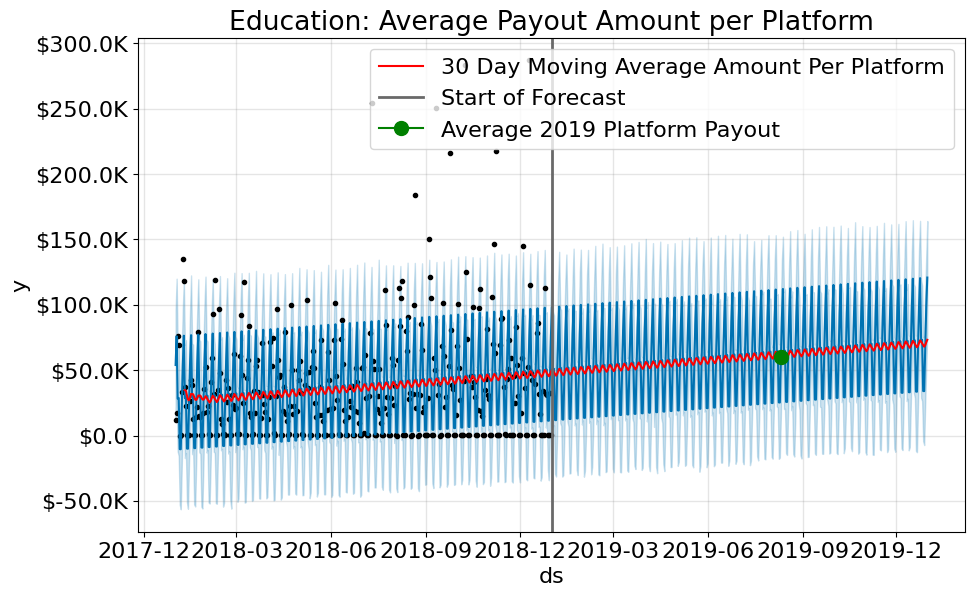

In [101]:
plt.clf()
plot_ind_forecast(industry)

## Food & Beverage 2019 Industry Forecast
- Use Facebook Prophet to forecast daily payout amount the average platform in the  Food & Beverage
***

In [102]:
industry = 'Food & Beverage'
# Determine Average Forecasted Amount per Platform
food_yhat_lower, food_yhat, food_yhat_upper = get_mean_ind_yhat(industry)
print('{0}\n Average Forecasted Daily Amount: {1} \n Lower Bound: {2}  \n Upper Bound: {3}'.format(industry, 
                                                                                                   food_yhat,
                                                                                                   food_yhat_lower, 
                                                                                                   food_yhat_upper))
print('________________________')


Food & Beverage
 Average Forecasted Daily Amount: 39098 
 Lower Bound: 8567  
 Upper Bound: 69699
________________________


### Food & Beverage forecast plot
**Prophet Plots Explanation:**
- Source: https://www.mikulskibartosz.name/prophet-plot-explained/ 
- Black dots: data used to train model
- Dark Blue Line: Predicted Output
- Light Blue Region: Uncertainty Intervals

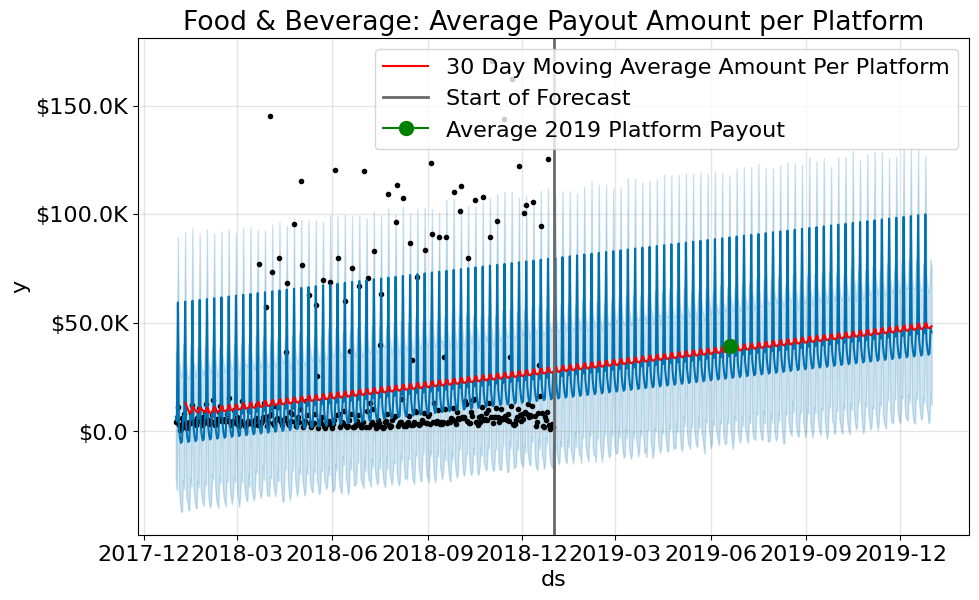

In [103]:
# Plot Forecasted Amount per Platform
plt.clf()
plot_ind_forecast(industry)

## Hotels, Restaurants & Leisure forecast
- There is only 1 instance of a playform payout from the hotels, restaurants & leisure
- I will approximate the hotels, restaurants & leisure industry with the next closest industry: **Travel & Leisure**
- **Key Assumption:** Travel & Leisure industry will closely approximate hotels, restaurants & leisure

In [104]:
industry = 'Travel & Hospitality'
# Determine Average Forecasted Amount per Platform
travel_yhat_lower, travel_yhat, travel_yhat_upper = get_mean_ind_yhat(industry)
print('{0}*\n Average Forecasted Daily Amount: {1} \n Lower Bound: {2}  \n Upper Bound: {3}'.format(industry, 
                                                                                                   travel_yhat,
                                                                                                   travel_yhat_lower, 
                                                                                                   travel_yhat_upper))
print('*note: Used Travel & Hospitality to approximate hotels, restaurants & leisure  due to sparse 2018 data')
print('________________________')


Travel & Hospitality*
 Average Forecasted Daily Amount: 43457 
 Lower Bound: 3245  
 Upper Bound: 83645
*note: Used Travel & Hospitality to approximate hotels, restaurants & leisure  due to sparse 2018 data
________________________


### Hotels, Restaurants & Leisure forecast plot
**Prophet Plots Explanation:**
- Source: https://www.mikulskibartosz.name/prophet-plot-explained/ 
- Black dots: data used to train model
- Dark Blue Line: Predicted Output
- Light Blue Region: Uncertainty Intervals

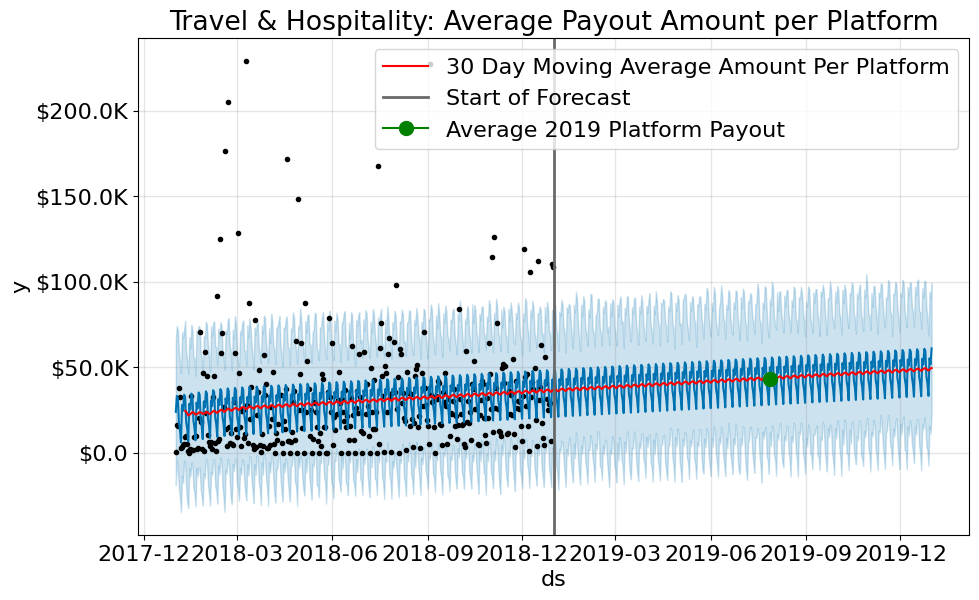

In [105]:
## ===== Note: using Travel & Hospitality to approximate hotels, restaurants & leisure due to sparse data =====
plt.clf()
plot_ind_forecast(industry)

# Q2 Final Plot: Forecasted Average Daily Payout Amount by Industry

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

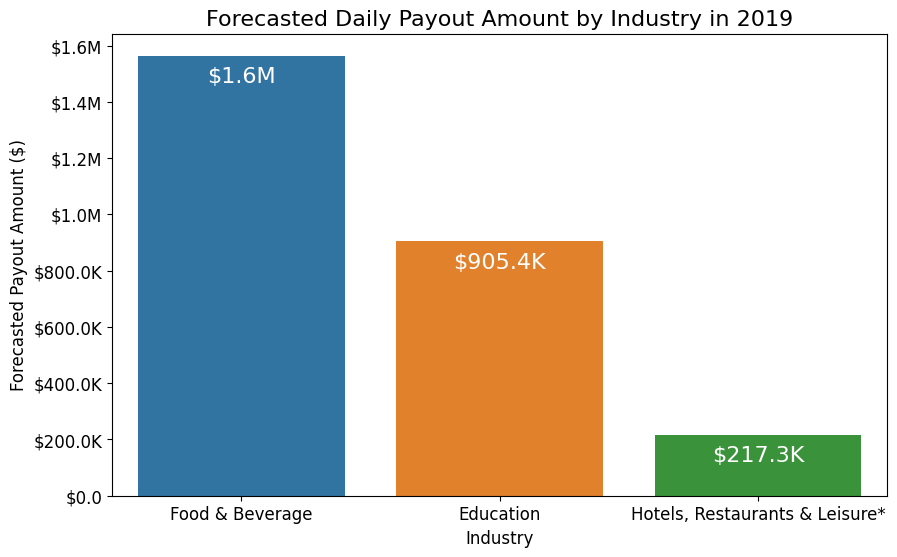

In [106]:
plt.clf()
bars_dict = {
    'industry': ['Education', 'Food & Beverage', 'Hotels, Restaurants & Leisure*'],
    'payout_amount': [education_yhat * 15, food_yhat * 40, travel_yhat * 5]
}
q2_df = pd.DataFrame.from_dict(bars_dict)

q2_df = q2_df.sort_values('payout_amount', ascending=False)

fig, ax1 = plt.subplots()
sns.barplot(x=q2_df.industry,
            y=q2_df.payout_amount,
            data=q2_df)

ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '${}'.format(format_number(x))))
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

ax1.set_ylabel('Forecasted Payout Amount ($)', fontdict={'fontsize':12})
ax1.set_xlabel('Industry', fontdict={'fontsize':12})
ax1.set_title('Forecasted Daily Payout Amount by Industry in 2019', fontdict={'fontsize':16})


# Add Data Labels for top 3 countries + for lower amounts 
for p in ax1.patches:
    # Reference for adding bar plot data labels: https://stackoverflow.com/questions/39444665/add-data-labels-to-seaborn-factor-plot 
    ax1.text(p.get_x() + p.get_width()/2, p.get_height()-110000, '${}'.format(format_number(p.get_height())), 
            fontsize=16, color='w', ha='center', va='bottom')
    
plt.show()

## Confirmation that hotels, restaurants & leisure has sparse data

### hotels, restaurants & leisure has 1 distinct platform id in 2018

In [107]:
payouts.groupby(['platform_industry'])['platform_id'].nunique().sort_values(ascending=True)

platform_industry
internet software & services                           1
Real Estate                                            1
Financial Services                                     1
hotels, restaurants & leisure                          1
Education                                              5
Healthcare                                             5
Content                                                6
Direct Services: classes,memberships,appointments      7
Other Retail                                          10
Tickets: concerts,sports,movies,conventions           10
Travel & Hospitality                                  12
Food & Beverage                                       15
Non-profit                                            16
Retail Fashion                                        19
Professional Services (non-medical)                   24
Other Services                                       105
Other Software & Content                             178
Name: platfor

### hotels, restaurants & leisure has 1 distinct payout in 2018

In [108]:
payouts.groupby(['platform_industry'])['amount'].count().sort_values(ascending=True)

platform_industry
hotels, restaurants & leisure                             1
internet software & services                             20
Real Estate                                              58
Financial Services                                      167
Other Retail                                           1810
Direct Services: classes,memberships,appointments      5429
Retail Fashion                                         7811
Education                                             23597
Content                                               25128
Healthcare                                            32718
Other Software & Content                             107632
Travel & Hospitality                                 116688
Other Services                                       142841
Food & Beverage                                      145922
Professional Services (non-medical)                  218930
Non-profit                                           255601
Tickets: concerts,spor